**Note: it is necessary to move this notebook to the notebook's root folder**

# Kmeans and DiffPool comparisons

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [127]:
s_male_dp = np.load(f'results/dp_interp_100_n_e_diffpool_male.npy')
s_female_dp = np.load(f'results/dp_interp_100_n_e_diffpool_female.npy')
s_total_dp = s_male_dp + s_female_dp


In [128]:
s_male_k = np.load(f'results/kmeans_clust_male.npy')
s_female_k = np.load(f'results/kmeans_clust_female.npy')

s_total_k = s_male_k + s_female_k

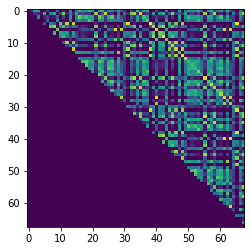

In [129]:
plt.imshow(s_total_k)


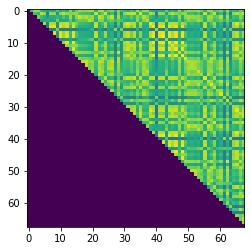

In [130]:
plt.imshow(s_total_dp)

/tmp/ipykernel_2053001/60911223.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((s_total_k - s_total_dp) / (s_total_k + s_total_dp))


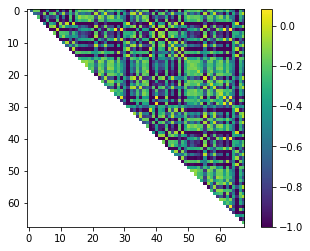

In [20]:
plt.imshow((s_total_k - s_total_dp) / (s_total_k + s_total_dp))
plt.colorbar()
plt.savefig('../figures/kmeans_dp_diff.pdf', bbox_inches = 'tight', pad_inches = 0)

In [135]:
np.nansum((s_total_k - s_total_dp) / (s_total_k + s_total_dp)) / ((68 * 67) / 2)

/tmp/ipykernel_10503/2058135632.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.nansum((s_total_k - s_total_dp) / (s_total_k + s_total_dp)) / ((68 * 67) / 2)


-0.5603154879897388

/tmp/ipykernel_2053001/1884391580.py:1: RuntimeWarning: invalid value encountered in true_divide
  _ = plt.hist(((s_total_k - s_total_dp) / (s_total_k + s_total_dp)).flatten())


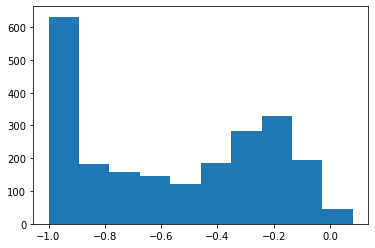

In [19]:
_ = plt.hist(((s_total_k - s_total_dp) / (s_total_k + s_total_dp)).flatten())

In [12]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, axes = plt.subplots(nrows=2, ncols=2)
cmap=cm.get_cmap('viridis')
normalizer=Normalize(0,4)
im=cm.ScalarMappable(norm=normalizer)
for i,ax in enumerate(axes.flat):
    ax.imshow(i+np.random.random((10,10)),cmap=cmap,norm=normalizer)
    ax.set_title(str(i))
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

-------- 100_n_diffpool :
-------- 100_n_e_diffpool :


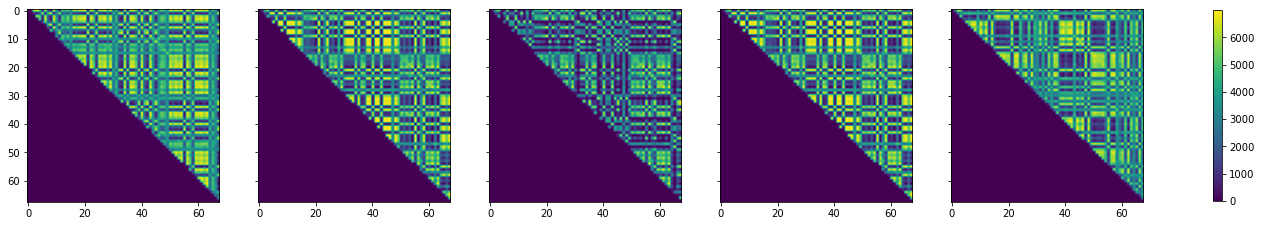

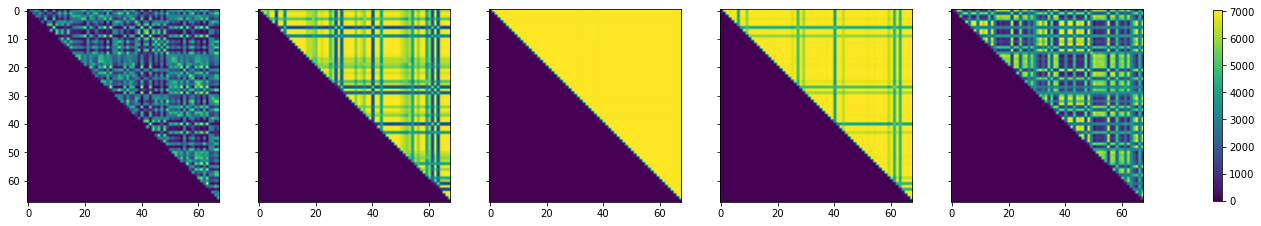

In [27]:
import matplotlib as mpl

for sweep_name in ['100_n_diffpool', '100_n_e_diffpool']:
    fig, axs = plt.subplots(1, 5, figsize=(25, 10), sharey=True)
    #fig.subplots_adjust(wspace=0.3)
    print('--------', sweep_name, ':')
    for i in range(5):
        s_total = np.load(f'../results/dp_interp_{sweep_name}_{i}_male.npy') + np.load(f'../results/dp_interp_{sweep_name}_{i}_female.npy')
        im = axs[i].imshow(s_total)
    
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #fig.colorbar(im, cax=cbar_ax)
    ##fig.colorbar(im, ax=axs.ravel().tolist())
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.35)
    
    plt.savefig(f'../figures/dp_robustness_{sweep_name}.pdf', bbox_inches = 'tight', pad_inches = 0)

In [144]:
all_totals = {}
sweep_name = '100_n_diffpool'
all_difs = np.zeros((5, 5))
    
    #fig.subplots_adjust(wspace=0.3)
for i in range(5):
    all_totals[i] = np.load(f'results/dp_interp_{sweep_name}_{i}_male.npy') + np.load(f'results/dp_interp_{sweep_name}_{i}_female.npy')

for i in range(5):
    for j in range(i, 5):
        all_difs[i, j] = round(np.nansum((all_totals[i] - all_totals[j]) / (all_totals[i] + all_totals[j])) / ((68 * 67) / 2), 3)

/tmp/ipykernel_10503/3381903953.py:11: RuntimeWarning: invalid value encountered in true_divide
  all_difs[i, j] = round(np.nansum((all_totals[i] - all_totals[j]) / (all_totals[i] + all_totals[j])) / ((68 * 67) / 2), 3)


In [159]:
all_difs

array([[ 0.   ,  0.101,  0.284,  0.108,  0.021],
       [ 0.   ,  0.   ,  0.244,  0.016, -0.059],
       [ 0.   ,  0.   ,  0.   , -0.238, -0.285],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.066],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

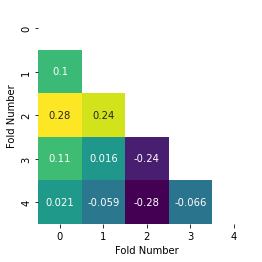

In [160]:
mask = np.zeros_like(all_difs)
mask[np.triu_indices_from(mask)] = True
             

s = sns.heatmap(all_difs.T, annot=True, mask=mask, cmap="viridis", square=True, cbar=False)

s.set_xlabel('Fold Number', fontsize=10)
s.set_ylabel('Fold Number', fontsize=10)

plt.savefig(f'figures/dp_robustness_normalised_diff_100_n_diffpool.pdf', bbox_inches = 'tight', pad_inches = 0)

# TCN Kernel comparisons

In [1]:
import wandb 
import torch

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import BrainDataset
from main_loop import generate_dataset, create_fold_generator, generate_st_model
from utils import calculate_indegree_histogram, change_w_config_, get_freer_gpu
from model import SpatioTemporalModel



In [121]:
run_ids = {
    8: 'yu7yn6hn',
    16: 'mj1e22ji',
    32: 'xuqxx0wy'
}

figsizes = {
    8: (5, 5),
    16: (5, 5),
    32: (3, 5)
}

In [124]:
for kernel_size in [8, 16, 32]:
    run_id = run_ids[kernel_size]
    api = wandb.Api()
    best_run = api.run(f'/tjiagom/st_extra/runs/{run_id}')
    w_config = best_run.config

    model_file_name = None
    for file in best_run.files():
        if file.name.endswith('.pt'):
            model_file_name = file.name
            file.download(replace=True)
            break

    change_w_config_(w_config)
    w_config['device_run'] = f'cuda:{get_freer_gpu()}'

    dataset: BrainDataset = generate_dataset(w_config)

    N_OUT_SPLITS: int = 5
    N_INNER_SPLITS: int = 5

    skf_outer_generator = create_fold_generator(dataset, w_config, N_OUT_SPLITS)

    # Getting train / test folds
    outer_split_num: int = 0
    for train_index, test_index in skf_outer_generator:
        outer_split_num += 1
        # Only run for the specific fold defined in the script arguments.
        if outer_split_num != w_config['fold_num']:
            continue

        X_train_out = dataset[torch.tensor(train_index)]
        X_test_out = dataset[torch.tensor(test_index)]

        break

    skf_inner_generator = create_fold_generator(X_train_out, w_config, N_INNER_SPLITS)
    inner_loop_run: int = 0
    for inner_train_index, inner_val_index in skf_inner_generator:
        inner_loop_run += 1

        X_train_in = X_train_out[torch.tensor(inner_train_index)]
        #X_val_in = X_train_out[torch.tensor(inner_val_index)]

        w_config['dataset_indegree'] = calculate_indegree_histogram(X_train_in)

        # model: SpatioTemporalModel = generate_st_model(run_cfg)
        model = SpatioTemporalModel(run_cfg=w_config,
                                    encoding_model=None
                                    ).to(w_config['device_run'])

        break
    model.load_state_dict(torch.load(model_file_name, map_location=w_config['device_run']))
    model.eval()
    
    _, ax = plt.subplots(figsize=figsizes[kernel_size])
    sns.heatmap(model.temporal_conv.network[0].conv1.weight.squeeze(1).detach().cpu().numpy(),
                ax=ax,
                #vmin=-0.2,
                #vmax=0.2,
                yticklabels=False, xticklabels=False,
                cmap='viridis')
    plt.savefig(f'figures/tcn_kernels_{kernel_size}.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.close()

Overriding GPU info and getting GPU 0...
Going for ./pytorch_data/unbalanced_weights_gender_ukb_st_unimodal_none_fmri_68_490_30_subject_norm
--> PNANodeModel going with aggregators=['mean', 'min', 'max', 'std', 'sum'], scalers=['identity']
Overriding GPU info and getting GPU 0...
Going for ./pytorch_data/unbalanced_weights_gender_ukb_st_unimodal_none_fmri_68_490_30_subject_norm
--> PNANodeModel going with aggregators=['mean', 'min', 'max', 'std', 'sum'], scalers=['identity']
Overriding GPU info and getting GPU 0...
Going for ./pytorch_data/unbalanced_weights_gender_ukb_st_unimodal_none_fmri_68_490_30_subject_norm
--> PNANodeModel going with aggregators=['mean', 'min', 'max', 'std', 'sum'], scalers=['identity']


torch.Size([8, 7])

torch.Size([32, 7])

(8, 7)

In [26]:
import matplotlib as mpl
class MidpointNormalize(mpl.colors.Normalize):
    ## class from the mpl docs:
    # https://matplotlib.org/users/colormapnorms.html

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))   

In [ ]:
# model.temporal_conv.network[0].conv1.weight.squeeze(1).detach().cpu().numpy(),

<AxesSubplot:>

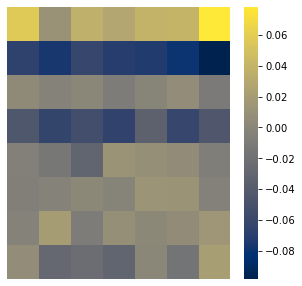

In [105]:
_, ax = plt.subplots(figsize=figsizes[kernel_size])
sns.heatmap(model.temporal_conv.network[0].conv1.weight.squeeze(1).detach().cpu().numpy(),
                ax=ax,
                yticklabels=False, xticklabels=False,
            #norm=MidpointNormalize(midpoint=-0.25),
            #vmin=-0.03,
            #vmax=0.03,
                cmap='cividis')

<AxesSubplot:>

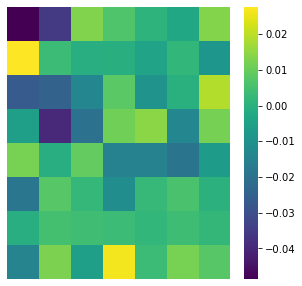

In [118]:
_, ax = plt.subplots(figsize=figsizes[kernel_size])
sns.heatmap(model.temporal_conv.network[0].conv1.weight.squeeze(1).detach().cpu().numpy(),
                ax=ax,
                yticklabels=False, xticklabels=False,
            #vmin=-0.1,
            #vmax=0.1,
                cmap='viridis')

In [80]:
model.temporal_conv.network[0].conv1.weight.shape

torch.Size([8, 1, 7])

In [69]:
model.temporal_conv.network[0].conv1.weight

Parameter containing:
tensor([[[ 0.0121, -0.0041,  0.0146, -0.0152, -0.0282, -0.0504, -0.0373]],

        [[-0.1925, -0.2112, -0.1984, -0.2103, -0.2112, -0.2117, -0.2138]],

        [[-0.2430, -0.2307, -0.2226, -0.2509, -0.2468, -0.2416, -0.2618]],

        [[ 0.1419,  0.1193,  0.1261,  0.1161,  0.1420,  0.1118,  0.1295]],

        [[-0.0053, -0.0143, -0.0320,  0.0118,  0.0084,  0.0047, -0.0073]],

        [[-0.0065, -0.0037,  0.0012, -0.0025,  0.0122,  0.0119, -0.0051]],

        [[-0.0032,  0.0200, -0.0089,  0.0084,  0.0017,  0.0046,  0.0142]],

        [[-0.2944, -0.3051, -0.2843, -0.2737, -0.2303, -0.2402, -0.2084]]],
       device='cuda:0', requires_grad=True)

In [70]:
model.temporal_conv.network[0].conv1.bias

Parameter containing:
tensor([ 0.4284, -0.0881, -0.0503,  0.1603, -0.3768, -0.3024, -0.3557,  0.0622],
       device='cuda:0', requires_grad=True)

In [97]:
torch.repeat_interleave(model.temporal_conv.network[0].conv1.bias, 7).reshape(8, 7)

tensor([[ 0.4284,  0.4284,  0.4284,  0.4284,  0.4284,  0.4284,  0.4284],
        [-0.0881, -0.0881, -0.0881, -0.0881, -0.0881, -0.0881, -0.0881],
        [-0.0503, -0.0503, -0.0503, -0.0503, -0.0503, -0.0503, -0.0503],
        [ 0.1603,  0.1603,  0.1603,  0.1603,  0.1603,  0.1603,  0.1603],
        [-0.3768, -0.3768, -0.3768, -0.3768, -0.3768, -0.3768, -0.3768],
        [-0.3024, -0.3024, -0.3024, -0.3024, -0.3024, -0.3024, -0.3024],
        [-0.3557, -0.3557, -0.3557, -0.3557, -0.3557, -0.3557, -0.3557],
        [ 0.0622,  0.0622,  0.0622,  0.0622,  0.0622,  0.0622,  0.0622]],
       device='cuda:0', grad_fn=<ViewBackward>)

In [96]:
model.temporal_conv.network[0].conv1.weight.squeeze(1) + torch.repeat_interleave(model.temporal_conv.network[0].conv1.bias, 7).reshape(8, 7)

tensor([[ 0.4405,  0.4243,  0.4431,  0.4132,  0.4002,  0.3780,  0.3911],
        [-0.2805, -0.2992, -0.2864, -0.2984, -0.2992, -0.2998, -0.3018],
        [-0.2934, -0.2810, -0.2729, -0.3012, -0.2971, -0.2919, -0.3121],
        [ 0.3021,  0.2795,  0.2863,  0.2763,  0.3023,  0.2721,  0.2898],
        [-0.3821, -0.3911, -0.4088, -0.3649, -0.3683, -0.3721, -0.3840],
        [-0.3089, -0.3060, -0.3011, -0.3049, -0.2901, -0.2905, -0.3075],
        [-0.3590, -0.3357, -0.3646, -0.3473, -0.3541, -0.3511, -0.3415],
        [-0.2322, -0.2429, -0.2221, -0.2115, -0.1681, -0.1780, -0.1462]],
       device='cuda:0', grad_fn=<AddBackward0>)

(array([ 5.,  8.,  8.,  0.,  0.,  2., 17.,  9.,  0.,  7.]),
 array([-0.3051147 , -0.2604015 , -0.21568832, -0.17097513, -0.12626195,
        -0.08154876, -0.03683557,  0.00787761,  0.0525908 ,  0.09730399,
         0.14201717], dtype=float32),
 <BarContainer object of 10 artists>)

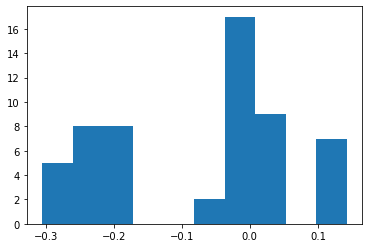

In [100]:
plt.hist(model.temporal_conv.network[0].conv1.weight.flatten().detach().cpu().numpy())